# HSE 2021: Mathematical Methods for Data Analysis

## Seminar 9: Gradient boosting
**Author**: Vadim Kokhtev

<center> 
    <table>
        <tr>
            <th> Class Teachers </th>
            <th> Contact </th>
            <th> Group </th>
            <th> TA (contact) </th>
        </tr> 
        <tr><td> Maksim Karpov </td><td> tg: @buntar29 </td><td> БПИ181, БПИ182 </td><td> Victor Grishanin (tg: @vgrishanin), Kirill Bykov (tg: @darkydash) </td></tr>
        <tr><td> Vadim Kokhtev </td><td> tg: @despairazure </td><td> БПИ183 </td><td> Daniil Kosakin (tg: @nieto95) </td></tr>
        <tr><td> Maria Tikhonova </td><td> tg: @mashkka_t </td><td> БПИ184 </td><td> Alexandra Kogan (tg: @horror_in_black) </td></tr>
        <tr><td> Polina Polinuna </td><td> tg: @ppolunina </td><td> БПИ185 </td><td> Michail Kim (tg: @kimihailv) </td></tr>        
    </table>

</center>

# Gradient Boosting
Gradient boosting (GB) is a machine learning algorithm developed in the late '90s that is still very popular. It produces state-of-the-art results for many commercial (and academic) applications. Gradient boosting builds an ensemble of trees one-by-one, then the predictions of the individual trees are summed.


 In boosting, several weak learners (high bias and low variance models) are combined additively to produce an ensemble with reduced bias while maintaining the low variance.

## Gradient boosting vs Random forest

First of all, we need to solve the task:

A sample of $\ell$ objects with $d$ features is given. Give the time asymptotics of learning and making predictions for a composition $a_N(x) = \sum_{n=0}^N b_n (x)$ over decision trees $b_n$ of depth at most $D$.

#### Solution

For training, we need to fit $N$ trees, so the asymptotics will be $N * T_{tree}$, where $T_{tree}$ is the complexity of constructing a single decision tree. When constructing a single tree, consider the complexity of finding the optimal partition at a single vertex. Consider how much time is spent on building a single level in the decision tree. Denote by $\ell^i_j$ - the number of objects from the training sample that reach the vertex $j$ at the $i$ - th level.


We need to check $d$ of features by the $\ell^i_j - 1$ thresholds. Calculating the partitioning quality metric takes $O (\ell^i_j)$ time. However, you can implement the $\textit{optimal}$ algorithm with pre-calculated statistics, which for each feature can calculate the metric for all $\ell^i_j - 1$ thresholds in $O(\ell^i_j)$ time. Hence, a single vertex requires $d * O (\ell^i_j) = O (d\ell^i_j)$ time.

It is clear that $\ell^1_1 = \ell$, since this is the root vertex. Further, for any $i, j$, it is true that $\ell^i_j = \ell^{i + 1}_{2j-1} + \ell^{i + 1}_{2j}$ by the principle of source-sink conservation (the number of objects originating from one vertex to its children is equal to the number of objects entering this vertex). It follows that in total there will be only $\ell$ objects on one level, $\forall i ~:~ \sum\limits^{2^i}_{j=1} \ell^i_j = \ell$. So, to build one level in the decision tree, we need only $ \sum \limits^{2^i}_{j=1} O (d\ell^i_j) = O (d\ell)$, and the levels are only $D$. Therefore, to build a single tree, you need $T_{tree} = O(Dd\ell)$ of time. We have $N$ trees, hence the total time to build all the trees, and hence for all the training: $O(NDd\ell)$

At the stage of constructing a forecast for the object $x$, it is "passed" through the tree from the root to the leaves, thereby passing a path of no more than $D$ internal vertices, each of which checks the predicate in constant time. Hence, we have the asymptotics for constructing the composition prediction - $O (ND)$.

### Changing the number of algorithms

Let's compare how boosting and bagging behave with the growth of the number of basic algorithms.

In the case of bagging, all the underlying algorithms are tuned to different samples from the same distribution at $\mathbb{X} \times \mathbb{Y}$. At the same time, some of them may be overfitted, but averaging allows you to weaken this effect (due to the fact that for uncorrelated algorithms, the spread of the composition is $N$ times less than the spread of individual algorithms, i.e. many trees are less likely to tune in to some atypical object compared to a single tree). If $N$ is large enough, then subsequent additions of new algorithms will no longer improve the quality of the model.

In the case of boosting, each algorithm is adjusted to the errors of all the previous ones, this allows you to adjust to the original distribution more and more accurately at each step. However, with a sufficiently large $N$, this is a source of overfitting, since subsequent additions of new algorithms will continue to tune to the training sample, reducing the error on it, while reducing the generalization ability of the final composition.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

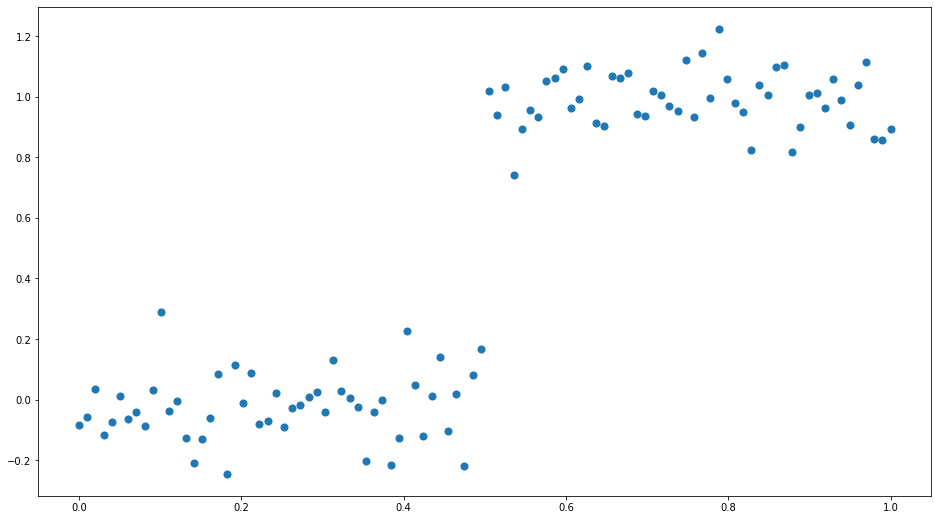

In [ ]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (16, 9))
plt.scatter(X_train, Y_train, s=50)

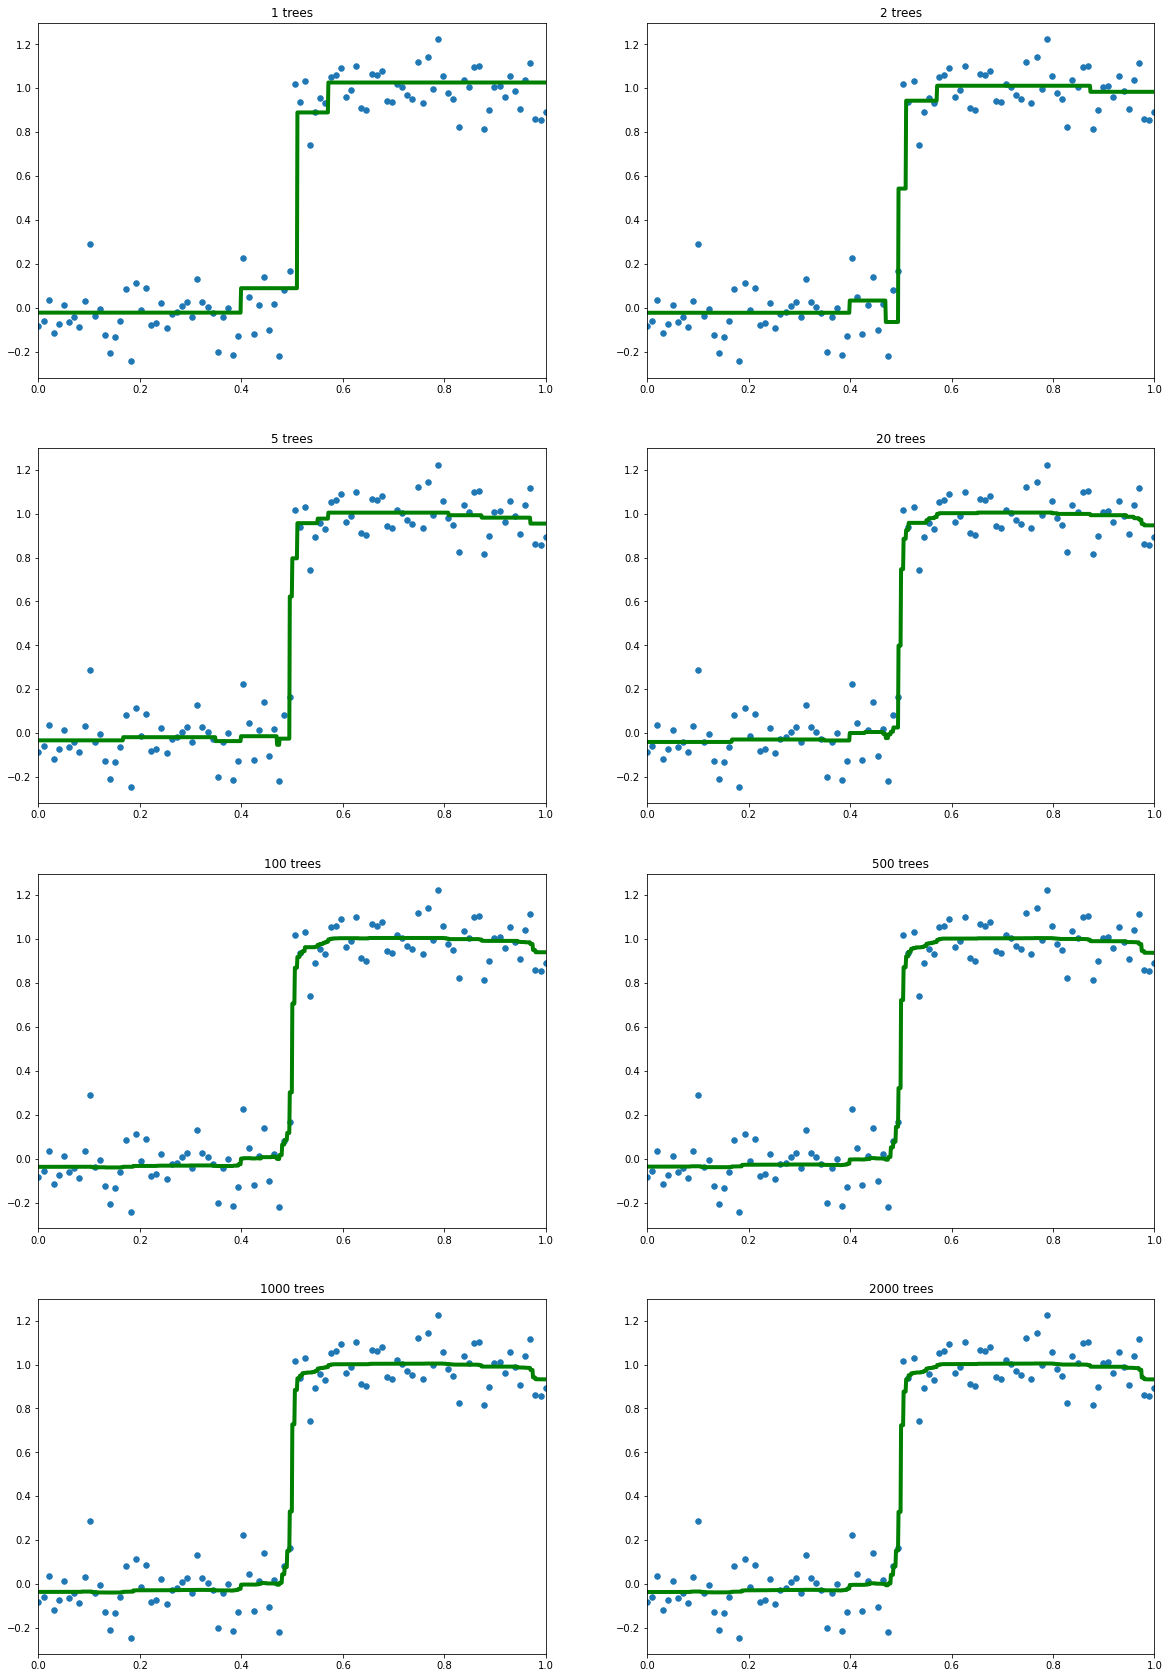

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

reg = BaggingRegressor(DecisionTreeRegressor(max_depth=2), warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

You can see that from some point on, the resulting function stops changing with the growth of the number of trees.

Now let's do the same for gradient boosting.

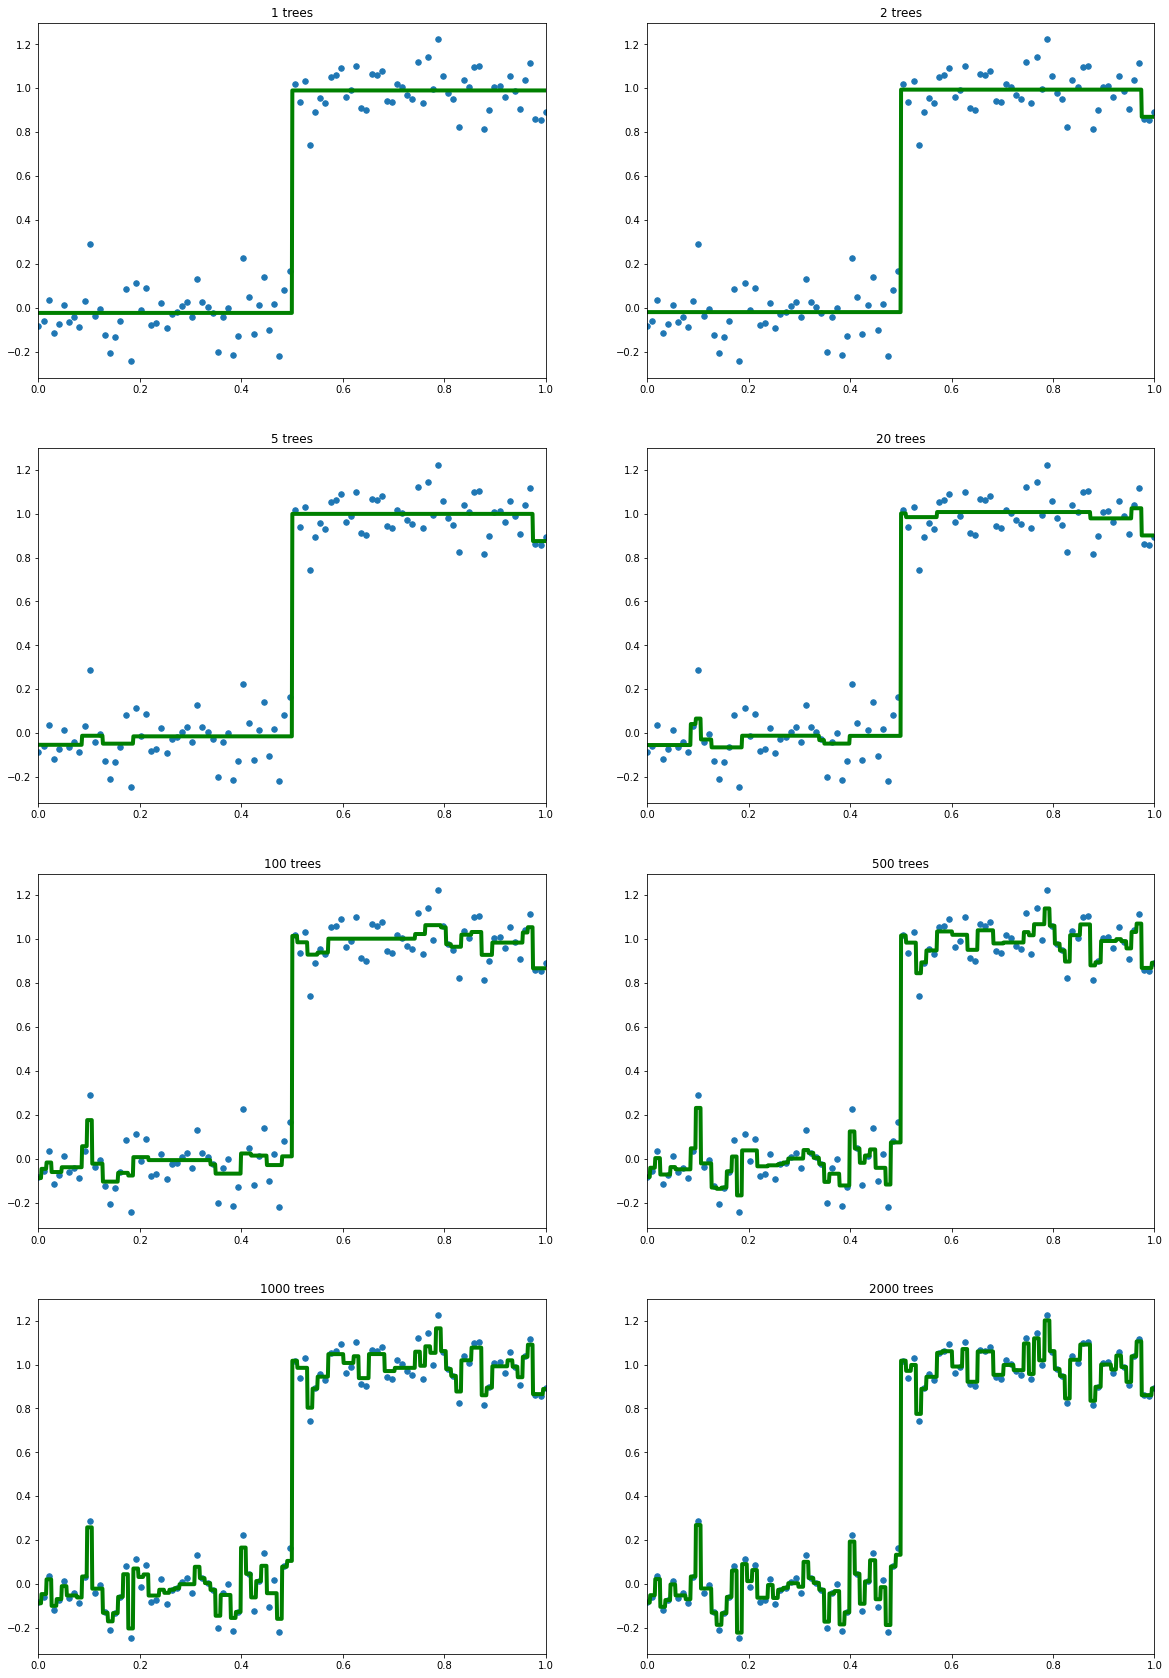

In [ ]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Gradient boosting quickly finds a true dependency, after which it begins adjusting to specific objects in the training sample, thus, it greatly overfits.

To deal with this problem, you can choose a very simple basic algorithm or
artificially reduce the weight of new algorithms using the step $\eta$:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$

This correction slows down learning compared to bagging, but it allows you to get reduce overfitting. However, it is important to understand that overfitting will still take place when training an arbitrarily large number of basic algorithms for a fixed $\eta$.

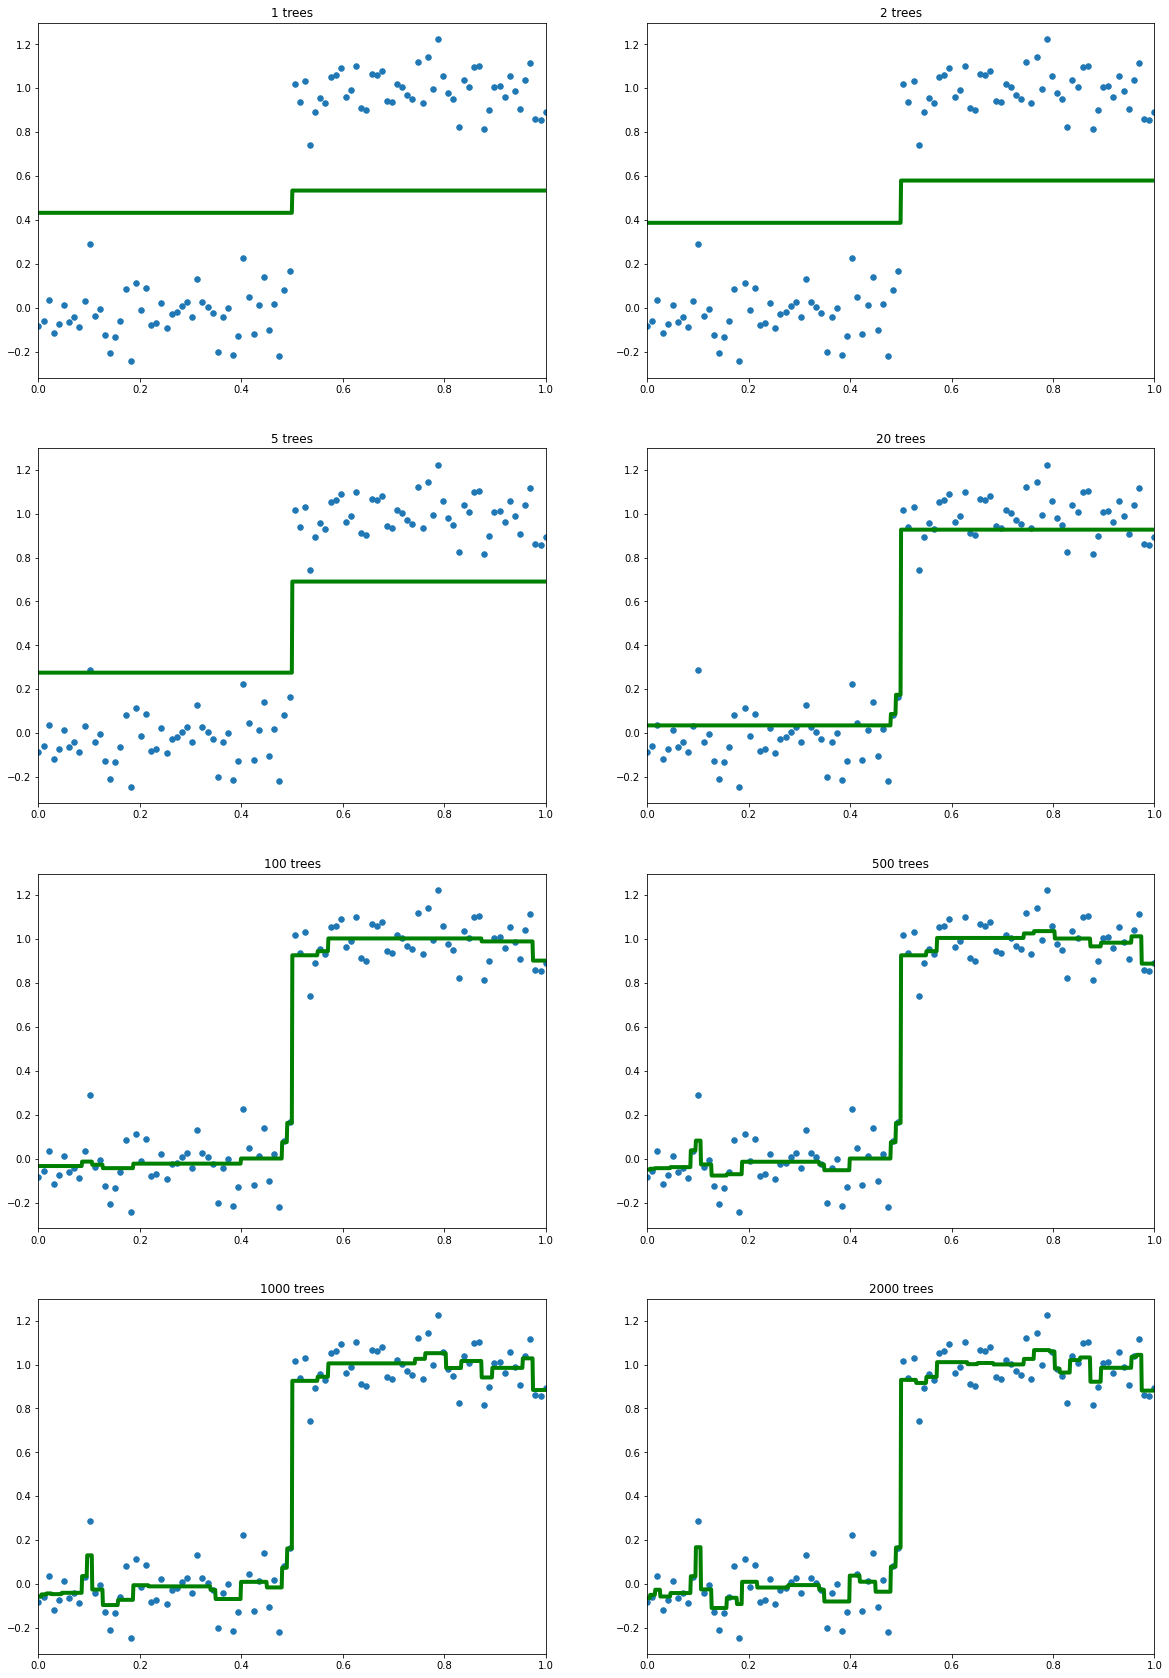

In [ ]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Now let's test the effect described above on real data.

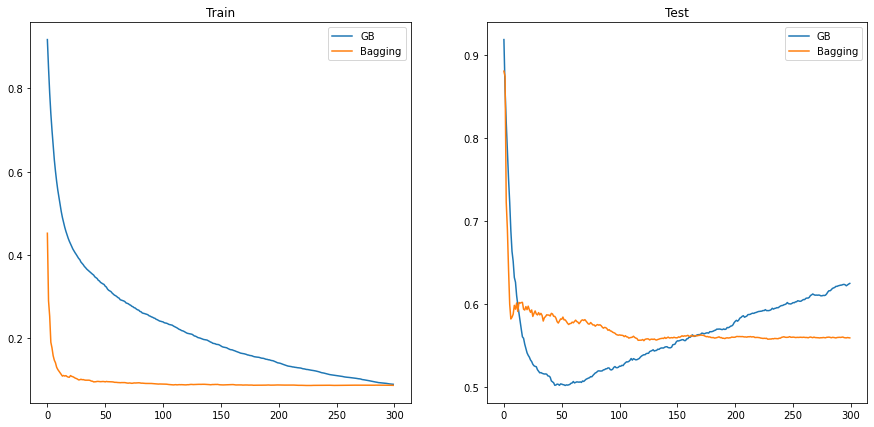

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)

MAX_ESTIMATORS = 300

gbclf = BaggingRegressor(warm_start=True)
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_bag.append(1 - gbclf.score(X_train, Y_train))
    err_test_bag.append(1 - gbclf.score(X_test, Y_test))
    
gbclf = GradientBoostingRegressor(warm_start=True, max_depth=2, learning_rate=0.1)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_gb.append(1 - gbclf.score(X_train, Y_train))
    err_test_gb.append(1 - gbclf.score(X_test, Y_test))
    
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.legend()
plt.title('Test')
plt.gcf().set_size_inches(15,7)

## Quality of algorithms

Let's compare the behavior of two methods. For this purpose let's construct a composition of algorithms over decision trees on [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) task:

The data is in the comma separated values (CSV) format. Each row in this data set represents a molecule. The first column contains experimental data describing a real biological response; the molecule was seen to elicit this response (1), or not (0). The remaining columns represent molecular descriptors (d1 through d1776), these are caclulated properties that can capture some of the characteristics of the molecule - for example size, shape, or elemental constitution. The descriptor matrix has been normalized.

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# https://drive.google.com/file/d/1yAOlsXMjSjI-XPwMGFq3PU6BKlib1xha
data = pd.read_csv('train.csv')
print(data.Activity.value_counts())
data.head()

1    2034
0    1717
Name: Activity, dtype: int64


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,...,D1737,D1738,D1739,D1740,D1741,D1742,D1743,D1744,D1745,D1746,D1747,D1748,D1749,D1750,D1751,D1752,D1753,D1754,D1755,D1756,D1757,D1758,D1759,D1760,D1761,D1762,D1763,D1764,D1765,D1766,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,0.243144,0.187856,0.0000,0.000000,0.069000,0.362012,0.301773,0.597930,0.190813,0.107219,0.070500,0.00717,0.137931,1,0.00,0.496683,0.753131,1,1,0.000000,0.262919,0.077200,0.082700,0.200590,0.00000,0.000000,0.0,0.0,0.162383,0.150153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,0.106480,0.101382,0.1875,0.193548,0.131001,0.350206,0.187419,0.762669,0.180473,0.329962,0.107681,0.01950,0.206897,0,0.75,0.449869,0.720484,0,0,0.666667,0.099400,0.289240,0.216710,0.100295,0.16958,0.235294,0.0,0.0,0.119104,0.075100,...,0,1,1,0,0,0,1,1,0,1,0,0,1,0,1,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,0.352308,0.193548,0.1250,0.000000,0.068900,0.574628,0.283327,0.510633,0.184480,0.073300,0.061600,0.00566,0.000000,1,0.00,0.486610,0.803577,0,1,0.000000,0.428659,0.032400,0.072400,0.000000,0.03930,0.000000,0.0,0.0,0.076100,0.225229,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,0.208989,0.000000,0.0000,0.000000,0.145947,0.584688,0.325247,0.496745,0.242288,0.087700,0.075300,0.01680,0.000000,1,0.00,0.459122,0.829482,0,1,0.000000,0.435410,0.118562,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.068900,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,0.125177,0.532258,0.0000,0.000000,0.094900,0.540323,0.116775,0.552982,0.167897,0.116140,0.054200,0.01350,0.103448,1,0.00,0.381883,0.913374,0,1,0.000000,0.305333,0.054100,0.170822,0.000000,0.00000,0.176471,0.0,0.0,0.019900,0.057400,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [ ]:
y_test

array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
%%time
gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, verbose=True).fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2613           15.30s
         2           1.1713           15.24s
         3           1.1007           15.04s
         4           1.0524           15.01s
         5           1.0125           14.82s
         6           0.9736           14.70s
         7           0.9441           14.70s
         8           0.9194           14.76s
         9           0.8950           14.62s
        10           0.8786           14.61s
        20           0.7166           14.42s
        30           0.5979           13.88s
        40           0.5150           13.31s
        50           0.4578           12.72s
        60           0.3984           12.07s
        70           0.3420           11.40s
        80           0.3078           10.77s
        90           0.2588           10.12s
       100           0.2241            9.47s
       200           0.0767            3.14s
CPU times: user 15.7 s, sys: 19.8 ms, total: 15.7 s
Wa

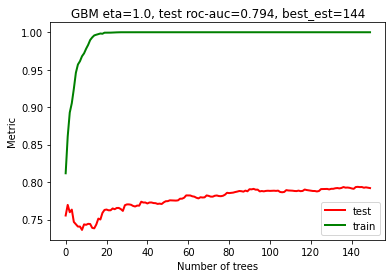

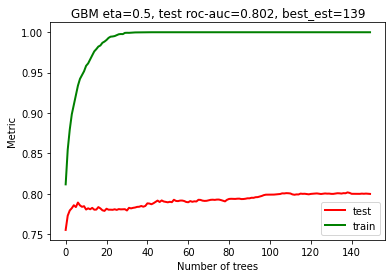

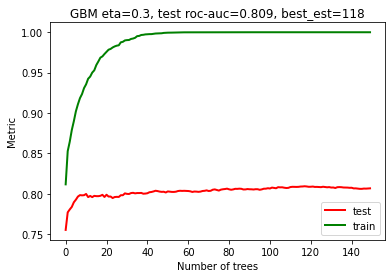

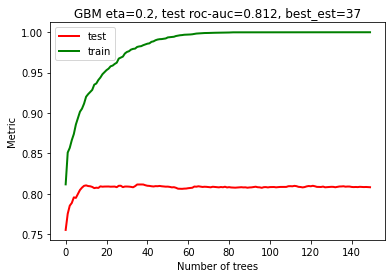

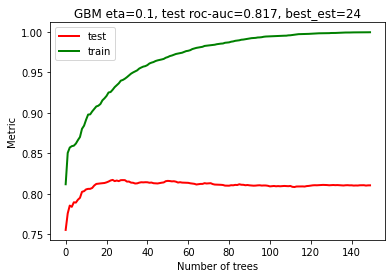

In [ ]:
from sklearn.metrics import roc_auc_score

for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    gbm = GradientBoostingClassifier(n_estimators=150, learning_rate=learning_rate, random_state=241).fit(X_train, y_train)
    
    l = roc_auc_score

    test_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_test)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        test_deviance[i] = roc_auc_score(y_test, y_pred)
    
    train_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_train)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        train_deviance[i] = roc_auc_score(y_train, y_pred)

    plt.figure()
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    
    plt.title('GBM eta=%.1f, test roc-auc=%.3f, best_est=%d' % (learning_rate, test_deviance.max(), test_deviance.argmax()+1))
    plt.xlabel('Number of trees')
    plt.ylabel('Metric')

In total, the best composition is built at $\eta = 0.1$. It includes 24 basic algorithms, and reaches a value of 0.816 on the control sample. At the same time, a random forest with the same number of basic algorithms is inferior to gradient boosting:

In [ ]:
rf = RandomForestClassifier(n_estimators=24, random_state=0).fit(X_train, y_train)
print ('Train RF ROC-AUC =', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
print ('Test RF ROC-AUC = ', roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Train RF ROC-AUC = 0.9999786482947104
Test RF ROC-AUC =  0.8037501166053144


Note also that with all this, random forest, unlike gradient boosting, uses deep trees that require computing power to train them.

To achieve the same quality, a random forest requires a much larger number of basic algorithms:

In [ ]:
for n_estimators in range(10, 101, 10):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=4).fit(X_train, y_train)
    print (n_estimators, 'trees: train ROC-AUC =',  roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]), 'test ROC-AUC =',  roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

10 trees: train ROC-AUC = 0.9989359733530718 test ROC-AUC = 0.7734582983517391
20 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8046309352104997
30 trees: train ROC-AUC = 0.9999928827649035 test ROC-AUC = 0.8175407131939809
40 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8094745405750615
50 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8194113315250541
60 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.81816141225181
70 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8205009184910913
80 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8231079442303691
90 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8198237107040091
100 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8200795696725722


Finally, you can see [visualization](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) gradient boosting for decision trees of different depths for functions of different types.

## Modern gradient boosting libraries

Previously, we used a naive version of gradient boosting from scikit-learn, [invented] (https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451) in 1999 by Friedman. Since then, many implementations have been proposed that prove to be better in practice. To date, three popular libraries that implement gradient boosting:
* XGBoost. After its release, it quickly gained popularity and remained the standard until the end of 2016. The features of this library were discussed at the lecture.
* LightGBM. A distinctive feature is the speed of composition construction. For example, the following trick is used to speed up learning: when building a tree vertex, instead of iterating over all the values of a feature, the values of the histogram of this feature are iterated over. So instead of $O (\ell)$ requires $O$(#bins). In addition, unlike other libraries that build a tree by levels, LightGBM uses the best-first strategy, i.e., at each step, it builds the vertex that gives the greatest reduction in the functional. Thus, each tree is a chain with attached leaves, so the restriction on num_leaves is more meaningful.
* CatBoost. Library from Yandex. Allows automatic processing of categorical features. In addition, the algorithm is less sensitive to the choice of specific hyperparameters. This reduces the time that a person spends on selecting the optimal hyperparameters.

### Basic parameters

(lightgbm/catboost)

* objective-the functionality that the composition will be configured for
* eta / learning_rate – learning rate
* num_iterations / n_estimators – number of boosting iterations

#### Parameters responsible for the complexity of trees
* max_depth – maximum depth
* max_leaves / num_leaves – the maximum number of vertices in the tree
* gamma / min_gain_to_split-threshold for reducing the error function when splitting in the tree
* min_data_in_leaf – minimum number of objects in the sheet
* min_sum_hessian_in_leaf – the minimum sum of the weights of objects in the sheet, the minimum number of objects at which splitting is done
* lambda-regularization coefficient (L2)
* subsample / bagging_fraction – which part of the learning objects to use to build a single tree
* colsample_bytree / feature_fraction – which part of the features to use to build a single tree

The selection of all these parameters is a real art. But you can start setting them up with the most important parameters: learning_rate and n_estimators. Usually, one of them is fixed, and the remaining of these two parameters is selected (for example, n_estimators=1000 is fixed and learning_rate is selected). Next in importance is max_depth. Due to the fact that we are interested in shallow trees, it is usually sorted out from the range [3; 7].

In [ ]:
! pip install lightgbm
! pip install --upgrade catboost==0.25

     |████████████████████████████████| 67.3MB 58kB/s 


In [ ]:
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

## Catboost

0.919452347083926


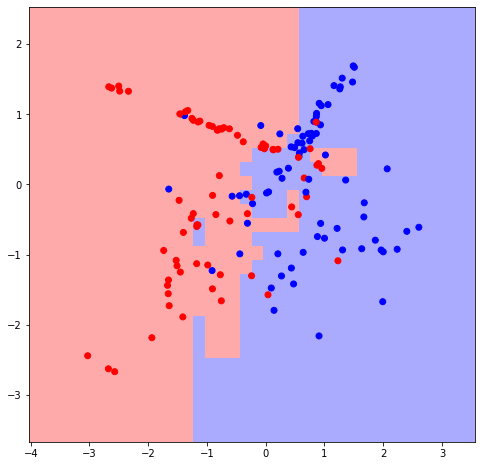

In [ ]:
from catboost import CatBoostClassifier 

clf = CatBoostClassifier(iterations=300, logging_level='Silent')
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

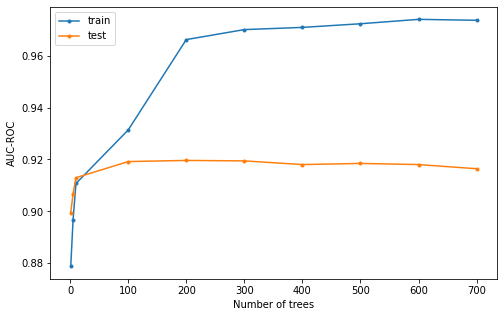

In [ ]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = CatBoostClassifier(iterations=n, logging_level='Silent')
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

## LightGBM

0.8629089615931721


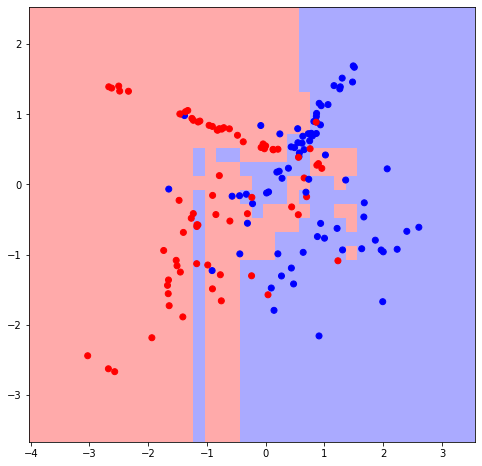

In [ ]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(n_estimators=300)
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

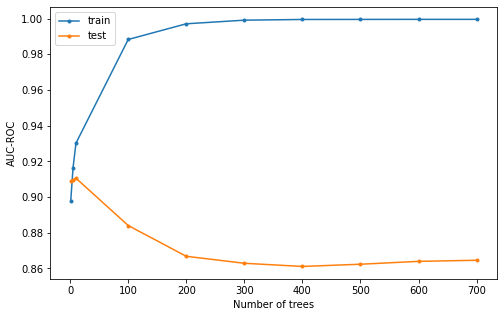

In [ ]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = LGBMClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Now we will try to take a fixed number of trees, but we will change the depth of them:

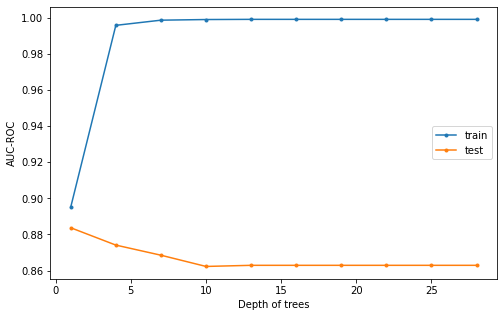

In [ ]:
depth = list(range(1, 30, 3))
n_trees = 300
quals_train = []
quals_test = []
for d in depth:
    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=d)
    lgb.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

And compare it with Catboost:

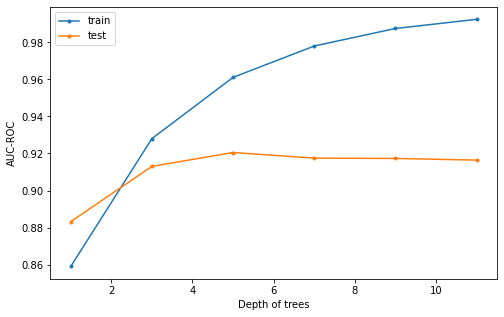

In [ ]:
depth = list(range(1, 12, 2))
n_trees = 300
quals_train = []
quals_test = []
for d in depth:
    clf = CatBoostClassifier(n_estimators=n_trees, max_depth=d, logging_level="Silent")
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Now that we have great models, we need to save them!

In [ ]:
lgb.booster_.save_model('lightgbm.txt')

clf.save_model('catboost.cbm', format='cbm')

And we'll upload them back when we need to apply them:

In [ ]:
lgb = LGBMClassifier(model_file='mode.txt')

clf = clf.load_model('catboost.cbm')

## Blending

As it was described in the lecture, blending is a "meta-algorithm", the prediction of which is built as a weighted sum of the basic algorithms. Consider a simple example of blending boosting and linear regression.

In [ ]:
from sklearn.datasets import load_boston

data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

In [ ]:
from catboost import CatBoostRegressor

cbm = CatBoostRegressor(iterations=100, max_depth=4, learning_rate=0.01, loss_function='RMSE', logging_level='Silent')
cbm.fit(X_train, y_train)

y_pred_cbm = cbm.predict(X_test)
y_train_pred_cbm = cbm.predict(X_train)

print("Train RMSE GB = %.4f" % rmse(y_train, y_train_pred_cbm))
print("Test RMSE GB = %.4f" % rmse(y_test, y_pred_cbm))

Train RMSE GB = 5.4431
Test RMSE GB = 6.5456


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_train_pred_lr = lr.predict(X_train_scaled)

print("Train RMSE LR = %.4f" % rmse(y_train, y_train_pred_lr))
print("Test RMSE LR = %.4f" % rmse(y_test, y_pred_lr))

Train RMSE LR = 4.4113
Test RMSE LR = 5.4154


For simplicity, we assume that the new algorithm $a(x)$ is represented as
$$
    a(x)
    =
    \sum_{n = 1}^{N}
    w_n b_n(x),
$$
where $\sum_{n} w_n =1$

In [ ]:
def select_weights(y_true, y_pred_1, y_pred_2):
    grid = np.linspace(0, 1, 1000)
    metric = []
    for w_0 in grid:
        w_1 = 1 - w_0
        y_a = w_0 * y_pred_1 + w_1 * y_pred_2
        metric.append([rmse(y_true, y_a), w_0, w_1])
    return metric

In [ ]:
rmse_blending_train, w_0, w_1 = min(select_weights(y_train, y_train_pred_cbm, y_train_pred_lr), key=lambda x: x[0])

In [ ]:
rmse_blending_train

4.273424051954005

In [ ]:
rmse(y_test, y_pred_cbm * w_0 +  y_pred_lr * w_1)

5.237314717927903

As a result, we get a better quality on the test sample than each algorithm separately.